<a href="https://colab.research.google.com/github/keiiigo/RecursosOpenSource/blob/main/Pulp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 38.0 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import itertools
import pulp
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import requests
import folium

In [20]:
import pandas as pd

data = pd.read_csv('clientescor.csv')

selected_ids = [1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 18, 19, 50, 60]

df = data[data['CustomerID'].isin(selected_ids)].copy()

depot_location = (-25.3775625, -57.4761875)

depot_df = pd.DataFrame({
    'CustomerID': [0],
    'Customer Name': ['Depot'],
    'Latitude': [depot_location[0]],
    'Longitude': [depot_location[1]],
    'Demand': [0]
})

final_df = pd.concat([depot_df, df[['CustomerID', 'Customer Name', 'Latitude', 'Longitude', 'Demand']]], ignore_index=True)

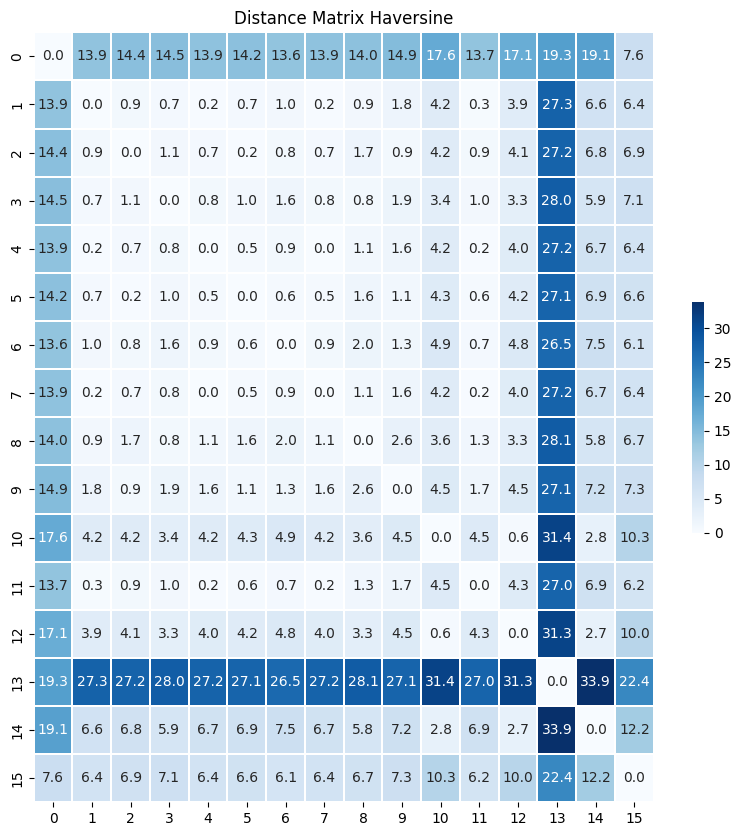

In [21]:
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    R = 6371.0
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

coords = final_df[['Latitude', 'Longitude']].values
n = len(coords)
distances = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        distances[i, j] = haversine(coords[i][0], coords[i][1], coords[j][0], coords[j][1])

distances_df = pd.DataFrame(distances, index=final_df.index, columns=final_df.index)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(distances_df, ax=ax, cmap='Blues', annot=True, fmt='.1f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.title('Distance Matrix Haversine')
plt.show()

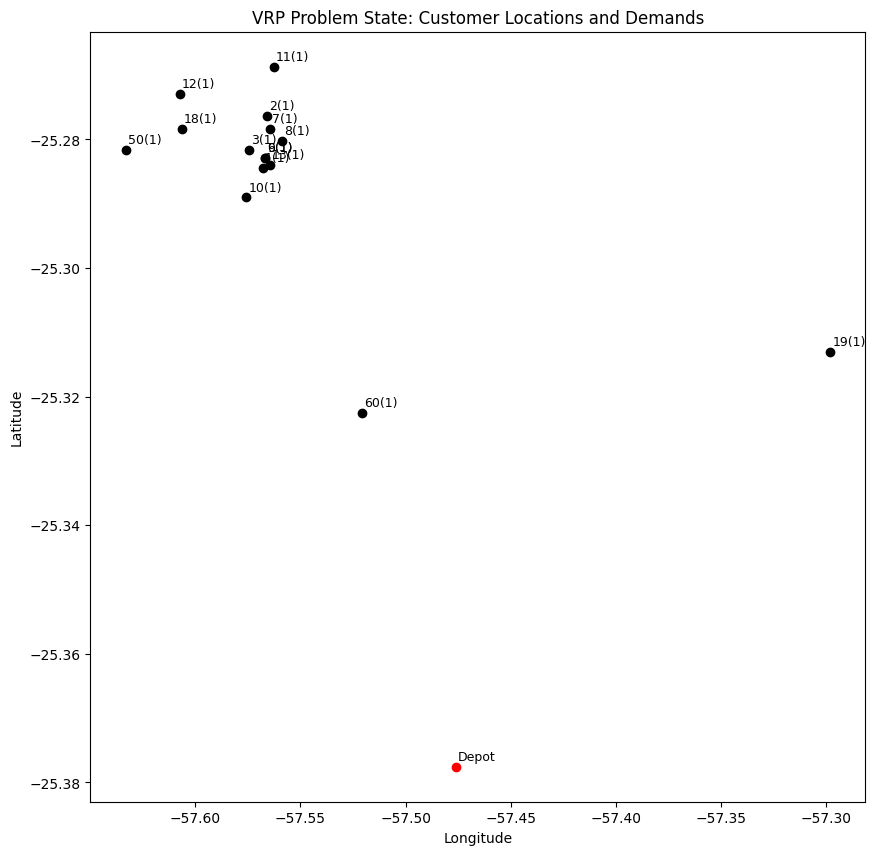

In [22]:
plt.figure(figsize=(10, 10))

for i, row in final_df.iterrows():
    if i == 0:
        plt.scatter(row['Longitude'], row['Latitude'], c='r', label='Depot')
        plt.text(row['Longitude'] + 0.001, row['Latitude'] + 0.001, 'Depot', fontsize=9)
    else:
        plt.scatter(row['Longitude'], row['Latitude'], c='black')
        plt.text(row['Longitude'] + 0.001, row['Latitude'] + 0.001, f"{row['CustomerID']}({row['Demand']})", fontsize=9)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('VRP Problem State: Customer Locations and Demands')
plt.show()

In [23]:
n_customer = len(final_df) - 1
n_point = len(final_df)

demands = final_df['Demand'].values

vehicle_capacity = 8

problem = pulp.LpProblem('cvrp_mip', pulp.LpMinimize)

x = pulp.LpVariable.dicts('x', ((i, j) for i in range(n_point) for j in range(n_point)), lowBound=0, upBound=1, cat='Binary')
n_vehicle = pulp.LpVariable('n_vehicle', lowBound=0, upBound=100, cat='Integer')
problem += pulp.lpSum([distances[i][j] * x[i, j] for i in range(n_point) for j in range(n_point)])

for i in range(n_point):
    problem += x[i, i] == 0

for i in range(1, n_point):
    problem += pulp.lpSum(x[j, i] for j in range(n_point)) == 1
    problem += pulp.lpSum(x[i, j] for j in range(n_point)) == 1

problem += pulp.lpSum(x[i, 0] for i in range(n_point)) == n_vehicle
problem += pulp.lpSum(x[0, i] for i in range(n_point)) == n_vehicle

subtours = []
for length in range(2, n_point):
    subtours += itertools.combinations(range(1, n_point), length)

for st in subtours:
    demand = np.sum([demands[s] for s in st])
    arcs = [x[i, j] for i, j in itertools.permutations(st, 2)]
    problem += pulp.lpSum(arcs) <= np.max([0, len(st) - np.ceil(demand / vehicle_capacity)])

status = problem.solve()

print(f"Status: {pulp.LpStatus[status]}")
print(f"Total Distance: {pulp.value(problem.objective)}")
print(f"Number of Vehicles: {pulp.value(n_vehicle)}")

Status: Optimal
Total Distance: 103.57021188057666
Number of Vehicles: 2.0


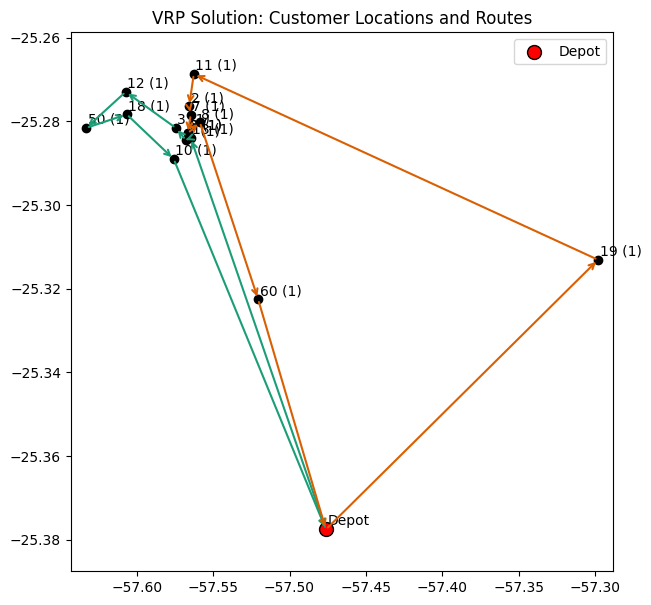

In [24]:
plt.figure(figsize=(7, 7))
plt.scatter(final_df.iloc[0]['Longitude'], final_df.iloc[0]['Latitude'], c='red', s=100, label='Depot', edgecolor='black')
plt.text(final_df.iloc[0]['Longitude'] + 0.001, final_df.iloc[0]['Latitude'] + 0.001, 'Depot')

for i, row in final_df.iterrows():
    if i > 0:
        plt.scatter(row['Longitude'], row['Latitude'], c='black', edgecolor='black')
        plt.text(row['Longitude'] + 0.001, row['Latitude'] + 0.001, f"{row['CustomerID']} ({row['Demand']})")

plt.xlim(final_df['Longitude'].min() - 0.01, final_df['Longitude'].max() + 0.01)
plt.ylim(final_df['Latitude'].min() - 0.01, final_df['Latitude'].max() + 0.01)
plt.title('VRP Solution: Customer Locations and Routes')

cmap = plt.get_cmap('Dark2')
routes = [(i, j) for i in range(n_point) for j in range(n_point) if pulp.value(x[i, j]) == 1]

for v in range(int(pulp.value(n_vehicle))):
    vehicle_route = [routes[v]]
    while vehicle_route[-1][1] != 0:
        for p in routes:
            if p[0] == vehicle_route[-1][1]:
                vehicle_route.append(p)
                break

    arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor=cmap(v), lw=1.5)
    for i, j in vehicle_route:
        plt.annotate('', xy=[final_df.iloc[j]['Longitude'], final_df.iloc[j]['Latitude']],
                     xytext=[final_df.iloc[i]['Longitude'], final_df.iloc[i]['Latitude']],
                     arrowprops=arrowprops)

plt.legend()
plt.show()

In [25]:
map_center = [depot_location[0], depot_location[1]]
mymap = folium.Map(location=map_center, zoom_start=12)

folium.Marker(
    location=[depot_location[0], depot_location[1]],
    popup='Depot',
    icon=folium.Icon(color='red', icon='home')
).add_to(mymap)

for i, row in final_df.iterrows():
    if i > 0:  # Skip depot
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=f"{row['Customer Name']} (Demand: {row['Demand']})",
            icon=folium.Icon(color='blue')
        ).add_to(mymap)

routes = [(i, j) for i in range(n_point) for j in range(n_point) if pulp.value(x[i, j]) == 1]
colors = ['blue', 'green', 'purple', 'orange', 'darkred', 'cadetblue']

visited_customers = set()

for v in range(int(pulp.value(n_vehicle))):
    vehicle_route = [0]  # Start at depot

    while True:
        last_customer = vehicle_route[-1]
        next_customer = None

        for p in routes:
            if p[0] == last_customer and p[1] not in visited_customers:
                next_customer = p[1]
                break

        if next_customer is None or next_customer == 0:
            break

        vehicle_route.append(next_customer)
        visited_customers.add(next_customer)

    vehicle_route.append(0)

    route_coords = [[final_df.iloc[i]['Latitude'], final_df.iloc[i]['Longitude']] for i in vehicle_route]
    folium.PolyLine(route_coords, color=colors[v % len(colors)], weight=2.5, opacity=1).add_to(mymap)

mymap